# Merge Graduation and Going to College Rate 

In [1]:
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
print(pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
1.19.2
1.1.3


### load grad_rate, coll_rate and public_school

In [9]:
# load grad_rate
gr = pd.read_csv('data/4_graduate_rate.csv')
gr.rename(columns = {'regular_hs_diploma_graduates_rate': 'graduates_rate', \
                     'regular_hs_diploma_graduates_count': 'graduates_count'}, inplace = True)


# load coll_rate and clean up
cr = pd.read_csv('raw_data/college_going.csv')
cr.columns = cr.columns.str.replace('\s+', '_').str.lower()
cr.columns = cr.columns.str.replace('-', '_')
cr.college_going_rate = cr.college_going_rate.str[:-1]
cr = cr.astype({'college_going_rate': float})
# Rename the columns 'name' to 'school_name' to match the column in dataFrame 'public_school'
cr.rename(columns = {'name': 'schoolname', 'high_school_completers': 'completers', \
                     'high_school_completers_enrolled_in_college': 'enrolled_in_college'}, inplace = True) 

# take out the comma from a number
cr.iloc[307,2]=1040
cr = cr.astype({'completers': int})

# load public_school and clean up
pub_school = pd.read_csv('data/8_public_school.csv')
pub_school.columns = pub_school.columns.str.replace('\s+', '_').str.lower()
pub_school.rename(columns = {'school_code': 'schoolcode'}, inplace = True)

# merge zipcode from public_school to subset of grad_rate
grad_rate = pub_school[['schoolcode', 'zip_code']].merge(gr[['districtcode', 'schoolcode', 'districtname', \
                                                             'schoolname', 'cohortstudents',\
                                                             'graduates_count', 'graduates_rate']], on = 'schoolcode')

# take subset of the public_school: school_code, school_name and zip _code, then merge with college_going
grad_coll = grad_rate.merge(cr[['college_going_rate', 'schoolname', 'completers', 'enrolled_in_college']], \
                            on = 'schoolname')
grad_coll.rename(columns = {'zip_code': 'zip'}, inplace = True)

# subset export for merging with test score
grad_coll_1 = grad_rate.merge(cr[['college_going_rate', 'schoolname', 'completers', 'enrolled_in_college']], \
                            on = 'schoolname', how='left')
grad_coll_1.rename(columns = {'zip_code': 'zip'}, inplace = True)
# export grad_coll merged data to csv
grad_coll_1.to_csv('data/12_grad_coll.csv', index=False)

# merge with house data
hv = pd.read_csv('data/7_house_by_year.csv')

# Final merge
grad_coll_house = grad_coll.merge(hv, on = 'zip')



In [10]:
grad_coll

,schoolcode,zip,districtcode,districtname,schoolname,cohortstudents,graduates_count,graduates_rate,college_going_rate,completers,enrolled_in_college
0,100776,91352,10199,Los Angeles County Office of Education,North Valley Military Institute College Prepar...,69,65,94.20,nan,nan,nan
1,109942,90042,77289,SBE - Los Angeles College Prep Academy,Los Angeles College Prep Academy,37,25,67.60,nan,nan,nan
2,112128,90255,10199,Los Angeles County Office of Education,Aspire Ollin University Preparatory Academy,78,74,94.90,nan,nan,nan
3,115030,90746,10199,Los Angeles County Office of Education,Magnolia Science Academy 3,55,53,96.40,nan,nan,nan
4,115212,91406,10199,Los Angeles County Office of Education,Magnolia Science Academy 2,40,38,95.00,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...
513,3030285,92604,73650,Irvine Unified,Woodbridge High,593,562,94.80,86.40,594.00,513.00
514,3030657,92620,73650,Irvine Unified,Northwood High,515,504,97.90,85.70,603.00,517.00
515,3035102,92612,73650,Irvine Unified,University High,559,532,95.20,85.70,665.00,570.00
516,3033917,90720,73924,Los Alamitos Unified,Los Alamitos High,756,736,97.40,84.50,824.00,696.00


In [176]:
by_zip2.head()

,cohortstudents,graduates_count,completers,enrolled_in_college,2020,grad_rate,coll_rate,grad_API
zip,,,,,,,,
90001,458,377,432,177,437487.17,82.31,40.97,3
90002,158,110,112,26,430948.67,69.62,23.21,2
90003,696,573,484,206,454610.08,82.33,42.56,3
90005,411,325,323,167,1598603.25,79.08,51.70,3
90007,659,581,524,253,821309.33,88.16,48.28,5


In [180]:
# 
by_zip = grad_coll_house.groupby('zip')
by_zip2 = by_zip.agg({'cohortstudents':'sum','graduates_count':'sum','completers':'sum','enrolled_in_college':'sum',\
           '2020':'mean'})
by_zip2['grad_rate'] = by_zip2.graduates_count/by_zip2.cohortstudents*100

# college_going_rate by zipcode
by_zip2['coll_rate'] = by_zip2.enrolled_in_college/by_zip2.completers*100

# calculate API for the graduate rate
bins = [0, 40, 70, 86, 88, 90, 92, 94, 96, 98, 100]
labels = list(range(1,11))
by_zip2['grad_API'] = pd.cut(by_zip2.grad_rate, bins=bins, labels=labels)
print(by_zip2.grad_API.value_counts())

bucket = [0, 20, 35, 50, 60, 70, 75, 80, 85, 90, 100]
by_zip2['coll_API'] = pd.cut(by_zip2.coll_rate, bins = bucket, labels = labels)
print(by_zip2.coll_API.value_counts())

by_zip2

8     43
9     40
3     29
7     28
6     22
10    21
5     10
4     10
2      7
1      2
Name: grad_API, dtype: int64
5     42
4     37
7     31
8     28
6     27
3     24
9     17
2      3
1      3
10     0
Name: coll_API, dtype: int64


,cohortstudents,graduates_count,completers,enrolled_in_college,2020,grad_rate,coll_rate,grad_API,coll_API
zip,,,,,,,,,
90001,458,377,432,177,437487.17,82.31,40.97,3,3
90002,158,110,112,26,430948.67,69.62,23.21,2,2
90003,696,573,484,206,454610.08,82.33,42.56,3,3
90005,411,325,323,167,1598603.25,79.08,51.70,3,4
90007,659,581,524,253,821309.33,88.16,48.28,5,3
...,...,...,...,...,...,...,...,...,...
93536,1451,1310,1299,914,395691.42,90.28,70.36,6,6
93543,348,271,283,163,314088.83,77.87,57.60,3,4
93550,831,496,636,334,312206.25,59.69,52.52,2,4


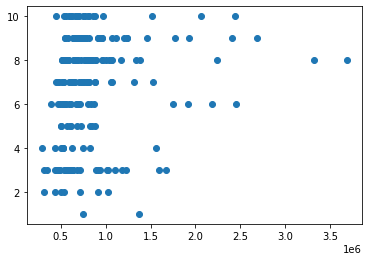

In [172]:
import seaborn as sns

plt.scatter('2020', 'grad_API', data=by_zip2)

0.913940674889683


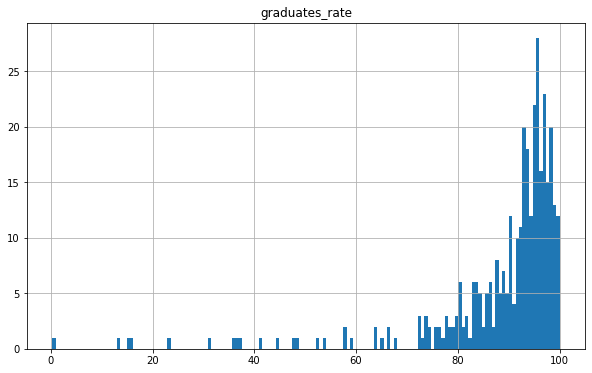

In [162]:
grad_coll_house.hist('graduates_rate', bins=150, figsize=(10,6))
average_grad = grad_coll_house.graduates_count.sum()/grad_coll_house.cohortstudents.sum()
print(average_grad)

0.6929191350956672


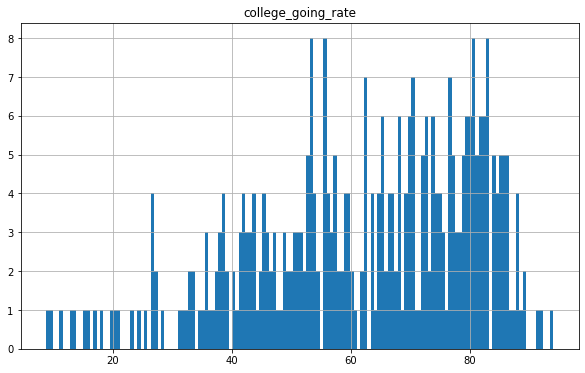

In [173]:
grad_coll_house.hist('college_going_rate', bins=150, figsize=(10,6))
average_coll = grad_coll_house.enrolled_in_college.sum()/grad_coll_house.completers.sum()
print(average_coll)

In [98]:
def crt_api(gr):
    if gr['college_going_rate'] >= 90:
        return 10
    elif gr['college_going_rate'] >= 80 and gr['college_going_rate'] < 90:
        return 9
    elif gr['college_going_rate'] >= 70 and gr['college_going_rate'] < 80:
        return 8
    elif gr['college_going_rate'] >= 60 and gr['college_going_rate'] < 70:
        return 7
    elif gr['college_going_rate'] >= 50 and gr['college_going_rate'] < 60:
        return 6
    elif gr['college_going_rate'] >= 40 and gr['college_going_rate'] < 50:
        return 5
    else:
        return 4
    

grad_coll['api'] = grad_coll.apply(lambda f: crt_api(f), axis = 1)

grad_coll.head()

,schoolcode,zip,districtcode,districtname,schoolname,graduates_rate,college_going_rate,api
0,121921,91750,10199,Los Angeles County Office of Education,Afflerbaugh-Paige Camp,41.40,24.40,4
1,1933399,90032,10199,Los Angeles County Office of Education,L.A. County High School for the Arts,90.30,80.30,9
2,1995869,91768,10199,Los Angeles County Office of Education,International Polytechnic High,96.90,86.40,9
3,1996214,90250,10199,Los Angeles County Office of Education,Renaissance County Community,31.40,18.00,4
4,1930056,90703,64212,ABC Unified,Cerritos High,96.00,79.00,8


In [45]:
by_district = grad_coll.groupby('districtcode')['graduates_rate', 'college_going_rate'].mean()

<ipython-input-45-a9b57bd0b942>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_district = grad_coll.groupby('districtcode')['graduates_rate', 'college_going_rate'].mean()


In [99]:
by_district.sort_values(by = ['college_going_rate'], ascending = False) 

,graduates_rate,college_going_rate
districtcode,,
64659,97.60,88.50
75333,97.20,88.20
64964,96.20,86.30
73460,96.50,85.95
65029,0.30,85.90
...,...,...
64352,84.20,48.62
64840,95.30,47.40
64279,89.17,43.57


<AxesSubplot:title={'center':'GraudateRat and CollegeGoingRate by Disctrict'}, xlabel='School District', ylabel='Grad_College_Rate'>

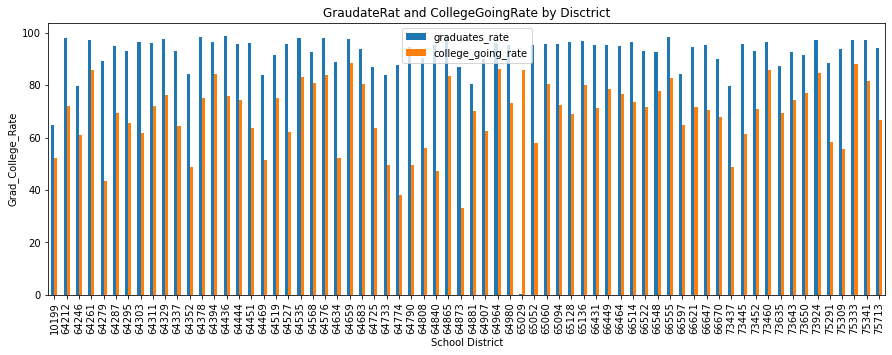

In [47]:
# fig, ax = plt.subplots(1,2)
# ax[0][0].scatter(by_district.graduates_rate)
# #plt.plot(by_district.graduates_rate)

by_district.plot.bar(title = 'GraudateRat and CollegeGoingRate by Disctrict', xlabel = 'School District',
                 ylabel = 'Grad_College_Rate', figsize = (15,5))
#plt.yscale('log')#plt.tittle('Donation Total and Average by Candidates')

### Top 10%  Graduate_Rate Districts

In [30]:
by_district.sort_values(by = ['college_going_rate'], ascending = False)

,graduates_rate,college_going_rate
districtcode,,
64659,97.60,88.50
75333,97.20,88.20
64964,96.20,86.30
73460,96.50,85.95
65029,0.30,85.90
...,...,...
64352,84.20,48.62
64840,95.30,47.40
64279,89.17,43.57


In [100]:
hv_by_year.sort_values(by = ['2020'])

,zip,city,county,1996,1997,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
347,93591,Palmdale,Los Angeles County,nan,nan,nan,nan,nan,nan,nan,...,95744.92,112387.92,136082.92,147356.50,161033.08,183394.00,214579.00,233425.17,250572.92,268097.50
361,93563,Valyermo,Los Angeles County,nan,nan,nan,nan,nan,nan,nan,...,217855.75,228979.33,231846.92,222675.25,239932.58,244581.00,271571.92,284192.92,277401.25,292978.00
101,93534,Lancaster,Los Angeles County,nan,nan,nan,nan,nan,nan,nan,...,116050.67,142801.25,165528.17,177277.33,194417.67,219991.75,248970.08,261220.08,283096.25,308503.50
26,93535,Lancaster,Los Angeles County,nan,nan,nan,nan,nan,nan,nan,...,120175.25,151193.67,173737.58,184351.92,203402.50,229347.75,258649.17,270279.33,291809.25,318031.50
354,93553,Pearblossom,Los Angeles County,87684.25,88963.58,92183.50,105616.25,107835.58,118074.42,128139.42,...,153530.08,174175.08,192439.17,206396.67,222652.17,243398.25,269030.33,279340.92,297848.25,325101.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,90272,Los Angeles,Los Angeles County,652812.08,663489.83,747211.75,838621.17,912429.00,1009887.92,1125627.92,...,1584940.42,1938197.58,2247372.92,2478974.75,2768149.50,3025528.92,3215173.00,3286443.08,3487516.92,3585904.50
327,92657,Newport Beach,Orange County,971148.00,1029980.83,1164652.08,1285754.17,1438814.33,1626672.67,1789182.08,...,2293178.50,2751765.17,2959944.33,3068071.58,3167932.00,3244809.00,3374040.33,3454174.67,3523014.33,3739468.00
274,90265,Malibu,Los Angeles County,527153.92,553822.42,620072.00,679644.75,769463.83,879575.17,999115.25,...,1609440.67,1917492.25,2187405.42,2438865.33,2769091.92,3059652.08,3395033.08,3530481.33,3683695.67,3870622.00
317,90402,Santa Monica,Los Angeles County,533058.67,560273.08,627405.00,706121.17,774868.17,857044.42,970502.75,...,1566417.50,1961964.50,2301570.92,2595341.33,2953821.83,3390201.50,3883398.50,4153323.83,4455595.08,4606773.50


In [118]:
grad_coll_house_20 = grad_coll_house[['zip', 'districtcode', 'districtname', 'schoolname', 'graduates_rate', \
                                      'college_going_rate', 'api', 'city', 'county', '2020']]
grad_coll_house_20

,zip,districtcode,districtname,schoolname,graduates_rate,college_going_rate,api,city,county,2020
0,91750,10199,Los Angeles County Office of Education,Afflerbaugh-Paige Camp,41.40,24.40,4,La Verne,Los Angeles County,716641.75
1,91750,64329,Bonita Unified,Bonita High,98.50,80.60,9,La Verne,Los Angeles County,716641.75
2,90032,10199,Los Angeles County Office of Education,L.A. County High School for the Arts,90.30,80.30,9,Los Angeles,Los Angeles County,682149.75
3,90032,64733,Los Angeles Unified,Woodrow Wilson Senior High,89.60,54.00,6,Los Angeles,Los Angeles County,682149.75
4,91768,10199,Los Angeles County Office of Education,International Polytechnic High,96.90,86.40,9,Pomona,Los Angeles County,472476.42
...,...,...,...,...,...,...,...,...,...,...
348,92604,73650,Irvine Unified,Irvine High,95.90,83.10,9,Irvine,Orange County,892102.92
349,92604,73650,Irvine Unified,Woodbridge High,94.80,86.40,9,Irvine,Orange County,892102.92
350,92620,73650,Irvine Unified,Northwood High,97.90,85.70,9,Irvine,Orange County,1110295.83
351,92612,73650,Irvine Unified,University High,95.20,85.70,9,Irvine,Orange County,843329.58


In [120]:
#district by house value
by_dist = grad_coll_house_20.groupby('districtcode')['graduates_rate', 'college_going_rate', '2020'].mean().sort_values(by = ['2020'], ascending = False)

<ipython-input-120-cdd5cab59809>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  by_dist = grad_coll_house_20.groupby('districtcode')['graduates_rate', 'college_going_rate', '2020'].mean().sort_values(by = ['2020'], ascending = False)
